In [1]:
from webdav3.client import Client
from dotenv import load_dotenv
load_dotenv()
import os
import pandas as pd
import xml.etree.ElementTree as ET
import regex as re
from tqdm import tqdm
import json
import requests
from requests.auth import HTTPBasicAuth
from io import BytesIO
from IPython.display import display, Image
from PIL import Image as PILImage
import gc
from sqlalchemy import create_engine, MetaData, Table, select, insert
from sqlalchemy.exc import SQLAlchemyError

DB_HOST = os.getenv("DB_HOST")
NC_ACC = os.getenv("NC_ACC")
NC_PASS = os.getenv("NC_PASS")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")


In [2]:
def webdav_login(server_url, username, password):
    try:
        # connect 2 webdav server
        client = Client({
            'webdav_hostname': server_url,
            'webdav_login': username,
            'webdav_password': password
        })

       #check connection
        if client.check():
            return client
        else:
            print("Wrong login data.")
            return None
    except Exception as e:
        print(f"Exception: {e}")
        return None


In [11]:
def get_meta(client, path, server_url):
    url=f"{server_url}{path}"
    # PROPFIND Anfrage senden
    response = client.session.request(
        method="PROPFIND",
        url=url,
        headers={'Depth': '1'},
        data="""<?xml version="1.0" encoding="utf-8"?>
    <d:propfind xmlns:d="DAV:" xmlns:oc="http://owncloud.org/ns">
        <d:prop>
            <oc:id/>
            <oc:fileid/>
            <oc:tags/>
            <d:getcontenttype/>
        </d:prop>
    </d:propfind>"""
    )

    # Parse XML response
    root = ET.fromstring(response.text)
    ns = {'oc': 'http://owncloud.org/ns'}
    fileid = root.find('.//oc:fileid', ns).text if root.find('.//oc:fileid', ns) is not None else None
    id = root.find('.//oc:id', ns).text if root.find('.//oc:id', ns) is not None else None
    tags = root.find('.//oc:tags', ns).text if root.find('.//oc:tags', ns) is not None else None
    #mime = root.find('.//d:getcontenttype').text if root.find('.//d:getcontenttype') is not None else 'unknown'
    regex = r"(?<=d\:getcontenttype\>)(.*)(?=\<\/d\:getcontenttype\>)"
    print(response.text)
    mime = re.search(regex, str(response.text))[0]
    return id, fileid, tags, mime


In [12]:
def folder_to_dict(path, client):
    entries = client.list(path)[1:]  # skip the listing of the directory itself
    children = {}
    for entry in entries:
        full_entry_path = path + entry
        if entry.endswith("/"):
            # recurse into subfolder
            children[entry] = folder_to_dict(full_entry_path, client)
        else:
            # file
            children[entry] = entry
    return children

In [13]:
def folder_to_dict_w_meta_tqdm(path, client, server_url):
    entries = client.list(path)[1:]  # skip the listing of the directory itself
    children = {}
    for entry in tqdm(entries):
        full_entry_path = path + entry
        if entry.endswith("/"):
            # recurse into subfolder
            children[entry] = folder_to_dict_w_meta(full_entry_path, client, server_url)
        else:
            # file: call file_id and store the response
            id, fileid, tags, mime = get_meta(client, full_entry_path, server_url)
            children[entry] = {"name": entry, "id": id, "fileid": fileid, "tags": tags, "path": full_entry_path, "mime": mime}
    return children


def folder_to_dict_w_meta(path, client, server_url):
    entries = client.list(path)[1:]  # skip the listing of the directory itself
    children = {}
    for entry in entries:
        full_entry_path = path + entry
        if entry.endswith("/"):
            # recurse into subfolder
            children[entry] = folder_to_dict_w_meta(full_entry_path, client, server_url)
        else:
            # file: call file_id and store the response
            id, fileid, tags, mime = get_meta(client, full_entry_path, server_url)
            children[entry] = {"name": entry, "id": id, "fileid": fileid, "tags": tags, "path": full_entry_path, "mime": mime}
    return children

In [14]:

server_url = f'''http://{DB_HOST}:8080/remote.php/dav/files/{NC_ACC}'''
username = NC_ACC
password = NC_PASS
path =  "/Bre/Artwork/AI_art/"
#path = "/Bre/"

client = webdav_login(server_url, username, password)

if client:
    print("client connected")
    root_dict = {path.strip("/").split("/")[-1]: folder_to_dict_w_meta_tqdm(path, client, server_url)}
    open("webdav_meta.json", "w").write(json.dumps(root_dict, indent=4))


    

client connected


  0%|          | 0/4 [00:00<?, ?it/s]

<?xml version="1.0"?>
<d:multistatus xmlns:d="DAV:" xmlns:s="http://sabredav.org/ns" xmlns:oc="http://owncloud.org/ns" xmlns:nc="http://nextcloud.org/ns"><d:response><d:href>/remote.php/dav/files/Tom/Bre/Artwork/AI_art/bearbeitet/Botti_ai%20Kopie.jpg</d:href><d:propstat><d:prop><oc:id>00019548ocus6w8qwy7q</oc:id><oc:fileid>19548</oc:fileid><oc:tags/><d:getcontenttype>image/jpeg</d:getcontenttype></d:prop><d:status>HTTP/1.1 200 OK</d:status></d:propstat></d:response></d:multistatus>

<?xml version="1.0"?>
<d:multistatus xmlns:d="DAV:" xmlns:s="http://sabredav.org/ns" xmlns:oc="http://owncloud.org/ns" xmlns:nc="http://nextcloud.org/ns"><d:response><d:href>/remote.php/dav/files/Tom/Bre/Artwork/AI_art/bearbeitet/bottitapete.jpg</d:href><d:propstat><d:prop><oc:id>00019557ocus6w8qwy7q</oc:id><oc:fileid>19557</oc:fileid><oc:tags/><d:getcontenttype>image/jpeg</d:getcontenttype></d:prop><d:status>HTTP/1.1 200 OK</d:status></d:propstat></d:response></d:multistatus>

<?xml version="1.0"?>
<d:mult

 25%|██▌       | 1/4 [00:03<00:09,  3.07s/it]

<?xml version="1.0"?>
<d:multistatus xmlns:d="DAV:" xmlns:s="http://sabredav.org/ns" xmlns:oc="http://owncloud.org/ns" xmlns:nc="http://nextcloud.org/ns"><d:response><d:href>/remote.php/dav/files/Tom/Bre/Artwork/AI_art/bearbeitet/tapete_morrison1.jpg</d:href><d:propstat><d:prop><oc:id>00019568ocus6w8qwy7q</oc:id><oc:fileid>19568</oc:fileid><oc:tags/><d:getcontenttype>image/jpeg</d:getcontenttype></d:prop><d:status>HTTP/1.1 200 OK</d:status></d:propstat></d:response></d:multistatus>



 50%|█████     | 2/4 [00:03<00:03,  1.50s/it]

<?xml version="1.0"?>
<d:multistatus xmlns:d="DAV:" xmlns:s="http://sabredav.org/ns" xmlns:oc="http://owncloud.org/ns" xmlns:nc="http://nextcloud.org/ns"><d:response><d:href>/remote.php/dav/files/Tom/Bre/Artwork/AI_art/blumen_unreal/flowerpower1.jpg</d:href><d:propstat><d:prop><oc:id>00019571ocus6w8qwy7q</oc:id><oc:fileid>19571</oc:fileid><oc:tags/><d:getcontenttype>image/jpeg</d:getcontenttype></d:prop><d:status>HTTP/1.1 200 OK</d:status></d:propstat></d:response></d:multistatus>

<?xml version="1.0"?>
<d:multistatus xmlns:d="DAV:" xmlns:s="http://sabredav.org/ns" xmlns:oc="http://owncloud.org/ns" xmlns:nc="http://nextcloud.org/ns"><d:response><d:href>/remote.php/dav/files/Tom/Bre/Artwork/AI_art/Botticelli/floral.jpg</d:href><d:propstat><d:prop><oc:id>00019736ocus6w8qwy7q</oc:id><oc:fileid>19736</oc:fileid><oc:tags/><d:getcontenttype>image/jpeg</d:getcontenttype></d:prop><d:status>HTTP/1.1 200 OK</d:status></d:propstat></d:response></d:multistatus>

<?xml version="1.0"?>
<d:multistatu

 75%|███████▌  | 3/4 [00:04<00:01,  1.19s/it]

<?xml version="1.0"?>
<d:multistatus xmlns:d="DAV:" xmlns:s="http://sabredav.org/ns" xmlns:oc="http://owncloud.org/ns" xmlns:nc="http://nextcloud.org/ns"><d:response><d:href>/remote.php/dav/files/Tom/Bre/Artwork/AI_art/Botticelli/spring%20flowers.jpg</d:href><d:propstat><d:prop><oc:id>00019606ocus6w8qwy7q</oc:id><oc:fileid>19606</oc:fileid><oc:tags/><d:getcontenttype>image/jpeg</d:getcontenttype></d:prop><d:status>HTTP/1.1 200 OK</d:status></d:propstat></d:response></d:multistatus>



100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

<?xml version="1.0"?>
<d:multistatus xmlns:d="DAV:" xmlns:s="http://sabredav.org/ns" xmlns:oc="http://owncloud.org/ns" xmlns:nc="http://nextcloud.org/ns"><d:response><d:href>/remote.php/dav/files/Tom/Bre/Artwork/AI_art/sealife/aquarium5.jpg</d:href><d:propstat><d:prop><oc:id>00019729ocus6w8qwy7q</oc:id><oc:fileid>19729</oc:fileid><oc:tags/><d:getcontenttype>image/jpeg</d:getcontenttype></d:prop><d:status>HTTP/1.1 200 OK</d:status></d:propstat></d:response></d:multistatus>

<?xml version="1.0"?>
<d:multistatus xmlns:d="DAV:" xmlns:s="http://sabredav.org/ns" xmlns:oc="http://owncloud.org/ns" xmlns:nc="http://nextcloud.org/ns"><d:response><d:href>/remote.php/dav/files/Tom/Bre/Artwork/AI_art/sealife/aquarium.jpg</d:href><d:propstat><d:prop><oc:id>00019728ocus6w8qwy7q</oc:id><oc:fileid>19728</oc:fileid><oc:tags/><d:getcontenttype>image/jpeg</d:getcontenttype></d:prop><d:status>HTTP/1.1 200 OK</d:status></d:propstat></d:response></d:multistatus>



In [7]:
def get_meta_fromdict(data):
    if len(data) == 1:
        first_val = next(iter(data.values()))
        content = first_val
    else:
        content = data

    for key, val in content.items():
        # if it's a folder entry (string that ends with "/") and val is mapping-like, recurse
        if key.endswith("/"):
            get_meta_fromdict(val)
            if getattr(val, "items", None):
                for subkey, subval in val.items():
                    if subkey in ("fileid", "name", "path"):
                        print('      ', subkey, subval)
                        continue
            else:
                # unexpected structure: just print the value
                #print('      ', key, val)
                return key, val


In [8]:
get_meta_fromdict(root_dict)

In [9]:
def flatten_dict_to_list(data):
    result_list = []
    
    def process_dict(content):
        for key, val in content.items():
            # If it's a folder entry
            if key.endswith("/"):
                if isinstance(val, dict):
                    process_dict(val)
            # If it's a file entry with metadata
            elif isinstance(val, dict) and 'name' in val:
                result_list.append(val)
    
    # Start with the root content
    if len(data) == 1:
        first_val = next(iter(data.values()))
        content = first_val
    else:
        content = data
        
    process_dict(content)
    return result_list

In [10]:
data_list = flatten_dict_to_list(root_dict)

In [ ]:
def get_images(file_id,file_path):
    server_url = f'''http://{DB_HOST}:8080/remote.php/dav/files/{NC_ACC}'''
    preview_url = f'''http://{DB_HOST}:8080/core/preview?fileId={file_id}&x=1080&y=1080'''
    username = NC_ACC
    password = NC_PASS

    # Construct the full URL
    file_url = f"{server_url}{file_path}"

    # Send a GET request to download the file
    response = requests.get(preview_url, auth=HTTPBasicAuth(username, password), stream=True)
 
    # Check if the request was successful
    if response.status_code == 200:
        # Save the file content in memory using BytesIO
        file_in_memory = BytesIO()
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file_in_memory.write(chunk)
        file_in_memory.seek(0)  # Move the pointer to the start of the BytesIO object
        size_in_bytes = len(file_in_memory.getvalue())
        size_in_mb = size_in_bytes / (1024 * 1024)  # Convert bytes to megabytes
        #print(f"Image size: {size_in_mb:.2f} MB")

        # Open the image using Pillow (PIL)
        img = PILImage.open(file_in_memory)
        w, h = img.size
        #print('width:', w, 'height:', h)
        img = img.resize((256, 256))
        display(img)
    elif response.status_code == 404:
        #print("No preview available for this file.")
        try:
            response = requests.get(file_url, auth=HTTPBasicAuth(username, password), stream=True)
            file_in_memory = BytesIO()
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file_in_memory.write(chunk)
            file_in_memory.seek(0)  # Move the pointer to the start of the BytesIO object
            size_in_bytes = len(file_in_memory.getvalue())
            size_in_mb = size_in_bytes / (1024 * 1024)  # Convert bytes to megabytes
            #print(f"File size: {size_in_mb:.2f} MB")
            source_img = PILImage.open(file_in_memory)
            img = source_img.resize((1080, 1080))
            img_display = source_img.resize((256, 256))
            display(img_display)
        except Exception as e:
            print(f"Failed to download file. Exception: {e}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")
        print(response.text)
    try:
        import gc
        del file_in_memory
        gc.collect()
    except:
        pass
    return img

In [99]:
data_test_list = data_list[0:5]

In [100]:
# Load the model
import mlx.core as mx
from mlx_vlm import load, generate
from mlx_vlm.prompt_utils import apply_chat_template
from mlx_vlm.utils import load_config

def load_model():
    model_path = "mlx-community/pixtral-12b-bf16"
    model, processor = load(model_path)
    config = load_config(model_path)
    return model, processor, config

In [101]:
def mlx_tags(image, prompt ,model,processor,config):
    formatted_prompt = apply_chat_template(processor, config, prompt, num_images=1)
    output = generate(model, processor, formatted_prompt, image, verbose=False)
    #print(output.text)
    #print( 'Generator token count:', output.generation_tokens , ' Generator tokens per second:', output.generation_tps)
    return output.text

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 36014.50it/s]


Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 128902.96it/s]


Botti_ai Kopie.jpg
Image size: 0.19 MB
width: 1080 height: 1080


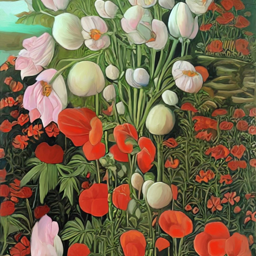

bottitapete.jpg
Image size: 0.18 MB
width: 1080 height: 1080


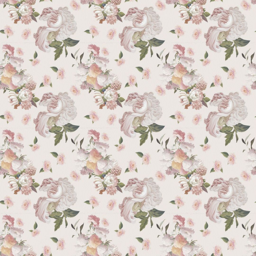

restarting mlx


Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 140893.93it/s]


bottitapete kleiner.jpg
Image size: 0.07 MB
width: 1080 height: 1080


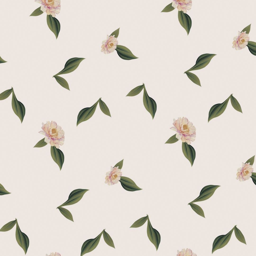

bottitapete kleiner Kopie.jpg
Image size: 0.14 MB
width: 1080 height: 1080


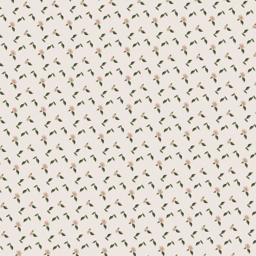

restarting mlx


Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 39770.94it/s]


bottitapete_quer.jpg
Image size: 0.11 MB
width: 810 height: 810


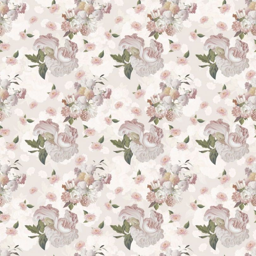

In [106]:
prompt = "Generate Tags for the image, for selling it in artsy online stores, no other text. Return seperated like: tag1;tag2;tag3. Max 15 tags. only use lemmatized words. Always include Art-style and color composition."
run_count = 1
gc.collect()
model, processor, config = load_model()
for i, item in enumerate(data_test_list):
    if run_count > 2:
        print('restarting mlx')
        del model, processor, config
        gc.collect()
        run_count = 1
        model, processor, config = load_model()
    print(item['name'])
    img = get_images(item['fileid'], item['path'])
    data_test_list[i]['tags'] = mlx_tags(img, prompt, model, processor, config)
    run_count = run_count + 1 


In [107]:
data_test_list

[{'name': 'Botti_ai Kopie.jpg',
  'id': '00019548ocus6w8qwy7q',
  'fileid': '19548',
  'tags': 'Art-style;Flower;Nature;Still-life;Vase;Red;White;Orange;Green;Bloom;Garden;Petal;Blossom;Paintings;Composition',
  'path': '/Bre/Artwork/AI_art/bearbeitet/Botti_ai Kopie.jpg',
  'mime': 'image/jpeg'},
 {'name': 'bottitapete.jpg',
  'id': '00019557ocus6w8qwy7q',
  'fileid': '19557',
  'tags': 'Floral;Pattern;Nature;Art-style;White;Pink;Green;Nature-inspired;Botanical;Bloom;Blossom;Petal;Leaf;Delicate;Soft;Elegant',
  'path': '/Bre/Artwork/AI_art/bearbeitet/bottitapete.jpg',
  'mime': 'image/jpeg'},
 {'name': 'bottitapete kleiner.jpg',
  'id': '00019549ocus6w8qwy7q',
  'fileid': '19549',
  'tags': 'Art-style;Floral;Pattern;Nature;Botanical;White;Green;Delicate;Soft;Pastel;Bloom;Leaf;Simplistic;Minimalist;Elegant',
  'path': '/Bre/Artwork/AI_art/bearbeitet/bottitapete kleiner.jpg',
  'mime': 'image/jpeg'},
 {'name': 'bottitapete kleiner Kopie.jpg',
  'id': '00019551ocus6w8qwy7q',
  'fileid': '

In [104]:

def create_db_connection():
    DB_HOST = os.getenv("DB_HOST")
    DB_NAME = os.getenv("DB_NAME")
    DB_USER = os.getenv("DB_USER")
    DB_PASSWORD = os.getenv("DB_PASSWORD")
    engine = create_engine('postgresql+pg8000://'+DB_USER+':'+DB_PASSWORD+'@'+DB_HOST+':5432/'+DB_NAME)
    return engine


def insert_tags_and_assign_to_files(file_list):
    try:
        engine = create_db_connection()
        metadata = MetaData()

        # Reflect the tables only once
        oc_systemtag = Table('oc_systemtag', metadata, autoload_with=engine)
        oc_systemtag_object_mapping = Table('oc_systemtag_object_mapping', metadata, autoload_with=engine)

        print("Columns in oc_systemtag:", oc_systemtag.columns.keys())

        with engine.connect() as conn:
            for file_info in file_list:
                file_id = file_info['fileid']
                tags_str = file_info['tags']
                tags = [tag.strip() for tag in tags_str.split(';')]

                # Step 1: Insert tags into oc_systemtag and collect tag_ids
                tag_ids = []
                for tag_name in tags:
                    # Check if the tag already exists
                    stmt = select(oc_systemtag.c.id).where(oc_systemtag.c.name == tag_name)
                    result = conn.execute(stmt)
                    row = result.fetchone()

                    if row:
                        tag_id = row[0]
                    else:
                        # Insert the new tag
                        insert_data = {'name': tag_name}
                        if 'user_visible' in oc_systemtag.columns:
                            insert_data['user_visible'] = True
                        if 'user_assignable' in oc_systemtag.columns:
                            insert_data['user_assignable'] = True

                        stmt = insert(oc_systemtag).values(**insert_data).returning(oc_systemtag.c.id)
                        result = conn.execute(stmt)
                        tag_id = result.fetchone()[0]

                    tag_ids.append(tag_id)

                # Step 2: Assign tags to the file in oc_systemtag_object_mapping
                for tag_id in tag_ids:
                    # Check if the mapping already exists
                    stmt = select(oc_systemtag_object_mapping).where(
                        oc_systemtag_object_mapping.c.systemtagid == tag_id,
                        oc_systemtag_object_mapping.c.objecttype == 'files',
                        oc_systemtag_object_mapping.c.objectid == file_id
                    )
                    result = conn.execute(stmt)
                    if not result.fetchone():
                        # Insert the mapping
                        stmt = insert(oc_systemtag_object_mapping).values(
                            systemtagid=tag_id,
                            objecttype='files',
                            objectid=file_id
                        )
                        conn.execute(stmt)

                print(f"Tags inserted and assigned successfully for {file_info['name']}!")

            # Commit the transaction once for all files
            conn.commit()

    except SQLAlchemyError as e:
        print(f"An error occurred: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [18]:
insert_tags_and_assign_to_files(data_list)

NameError: name 'insert_tags_and_assign_to_files' is not defined

In [19]:
def create_db_connection():
    DB_HOST = os.getenv("DB_HOST")
    DB_NAME = os.getenv("DB_NAME")
    DB_USER = os.getenv("DB_USER")
    DB_PASSWORD = os.getenv("DB_PASSWORD")
    engine = create_engine('postgresql+pg8000://'+DB_USER+':'+DB_PASSWORD+'@'+DB_HOST+':5432/'+DB_NAME)
    return engine


def get_file_ids_of_tagged_images():
    try:
        engine = create_db_connection()
        metadata = MetaData()

        # Reflect the oc_systemtag_object_mapping table
        oc_systemtag_object_mapping = Table('oc_systemtag_object_mapping', metadata, autoload_with=engine)

        # Query to fetch all file IDs that have tags
        stmt = select(oc_systemtag_object_mapping.c.objectid).where(
            oc_systemtag_object_mapping.c.objecttype == 'files'
        ).distinct()

        with engine.connect() as conn:
            result = conn.execute(stmt)
            file_ids = [row[0] for row in result.fetchall()]

        print(f"Found {len(file_ids)} tagged images.")
        return file_ids

    except Exception as e:
        print(f"An error occurred: {e}")
        return []
    
def filter_untagged_images(data_list, tagged_file_ids):
    # Filter out images that are already tagged
    untagged_images = [image for image in data_list if image['fileid'] not in tagged_file_ids]
    return untagged_images

# Get tagged file IDs from the database
tagged_file_ids = get_file_ids_of_tagged_images()

# Filter out already tagged images
untagged_images = filter_untagged_images(data_list, tagged_file_ids)

print(f"Found {len(untagged_images)} untagged images:")
for image in untagged_images:
    print(f"Name: {image['name']}, File ID: {image['fileid']}")

Found 3 tagged images.
Found 33 untagged images:
Name: bottitapete kleiner Kopie.jpg, File ID: 19551
Name: bottitapete_quer.jpg, File ID: 19552
Name: bottitapete vert.jpg, File ID: 19550
Name: botti-topaz-denoise-enhance.tiff, File ID: 19816
Name: esccehr bruecke4-topaz-denoise-enhance.tiff, File ID: 19784
Name: haeckel4-topaz-denoise-enhance.tiff, File ID: 19805
Name: klein-venedig-topaz-denoise-enhance.jpg, File ID: 19555
Name: Klimt1 Kopie.jpg, File ID: 19563
Name: klimt bruecke2-topaz-denoise-enhance.tiff, File ID: 19793
Name: pillows botti Kopie.jpg, File ID: 19558
Name: stores_morrison1b.jpg, File ID: 19561
Name: stores_morrison1b_kl.jpg, File ID: 19565
Name: stores_morrison1c.jpg, File ID: 19562
Name: tapete_morrison_100_bleu_muster_web.jpg, File ID: 19559
Name: tapete_morrison_100_muster_web.jpg, File ID: 19560
Name: tapete_morrison1 bigger.jpg, File ID: 19564
Name: tapete_morrison1big.jpg, File ID: 19570
Name: tapete_morrison1b.jpg, File ID: 19790
Name: tapete_morrison1c bigge